In [15]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict
import gym
import numpy as np

In [16]:
class WindyGridWorld():
  def __init__(self,pawn_moves,king_moves,stochastic=False):
    self.rows = 7
    self.columns = 10
    self.num_of_states = self.rows * self.columns
    self.x_max = self.columns - 1
    self.y_max = self.rows - 1
    self.windy_1 = [3, 4, 5, 8]
    self.windy_2 = [6, 7]
    self.pawn_moves = pawn_moves
    self.king_moves = king_moves
    self.stochastic = stochastic

    if (self.pawn_moves and self.king_moves) or (not self.pawn_moves and not self.king_moves):
        raise Exception("only one of the value for pawn_moves and king_moves parameters must be True and the another is False, both values cannot be the same")
    if self.pawn_moves:
        self.possible_actions = ['UP','DOWN','LEFT','RIGHT']
    elif self.king_moves:
        self.possible_actions = ['UP','DOWN','LEFT','RIGHT','UP-right','UP-left','DOWN-right','DOWN-left']
        self.stochastic = True
    if self.pawn_moves and stochastic:
        raise Exception("This world is designed to make stochastic moves only with king_moves not pawn_moves")
  def predifend_states(self, startState, goalState):
        # startState and goalState are tuples
        self.start = self.current_state(startState)
        self.terminal = self.current_state(goalState)

  def current_state(self,position):
        return position[1] + self.columns * position[0]
 
  def get_next_state(self,position,action):
    pos_x = int(position % self.columns)
    pos_y = int((position - pos_x) / self.columns)
    del_x = 0
    del_y = 0
    if self.pawn_moves:
        try:
            if action == 'RIGHT':
                    del_x = 1
            elif action == 'LEFT':
                    del_x = -1
            elif action == 'UP':
                    del_y = -1
            elif action == 'DOWN':
                    del_y = 1
        except ValueError:
                return 'Invalid action value'
        except TypeError:
                return 'Invalid action type'
        new_x = max(0, min(pos_x + del_x, self.x_max))
        new_y = max(0, min(pos_y + del_y, self.y_max))
        #When wind blows to a new state
        if new_x in self.windy_1:
            new_y = max(0, new_y - 1)
        if new_x in self.windy_2:
            new_y = max(0, new_y - 2)
        # now let's return these new state values
    elif self.king_moves:
        try:
            if action == 'RIGHT':
                del_x = 1
            elif action == 'LEFT':
                del_x = -1
            elif action == 'UP':
                del_y = -1
            elif action == 'DOWN':
                del_y = 1
            if action == 'UP-right':
                del_x = 1
                del_y = -1
            elif action == 'UP-left':
                del_x = -1
                del_y = -1
            elif action == 'DOWN-right':
                del_x = 1
                del_y = 1
            elif action == 'DOWN-left':
                del_x = -1
                del_y = 1
        except ValueError:
                return 'Invalid action value'
        except TypeError:
                return 'Invalid action type'
        new_x = max(0, min(pos_x + del_x, self.x_max))
        new_y = max(0, min(pos_y + del_y, self.y_max))
        #When wind blows to a new state
        if new_x in self.windy_1:
            new_y = max(0, new_y - 1)
        if new_x in self.windy_2:
            new_y = max(0, new_y - 2)
        if self.stochastic:
            choice = np.random.choice([1,0,-1],1,p=[1/3,1/3,1/3])
            new_y = max(0, min(new_y + choice[0],self.y_max))
    return self.current_state((new_y,new_x))


  def isTerminal(self, state):
      return state == self.terminal
    
  def rewardFunction(self, next_state):
      # When it reaches goal state then reward is 0 else all actions should yield -1
      if next_state == self.terminal:
          return 0
      else:
          return -1

def optimalPath(world, path,algorithm, alpha, epsilon):
    # Initialize gridworld
    world_map = np.zeros((world.rows, world.columns))
    states = []
    for i,state in enumerate(path):
        x = int(state % world.columns)
        y = int((state - x) / world.columns)
        states.append(state)
        world_map[y, x] = i + 1
    print("\n")
    print(f"Optimial path using {algorithm} with alpha: {alpha} and epsilon: {epsilon}")
    print(world_map)
    print("\n")
    return len(states)

In [17]:
### SolveWindyGridWorld class
class SolveWindyGridWorld():
    def __init__(self,world, startState, terminalState, sarsa, q_learning, alpha, epsilon,gamma):
        self.world = world
        self.sarsa = sarsa
        self.q_learning = q_learning
        if (self.sarsa and self.q_learning) or (not self.sarsa and not self.q_learning):
            raise Exception("only one of the value for sarsa and q_learning parameters must be True and the another is False, both values cannot be the same")
        self.q_table = {}
        for state in range(world.rows * world.columns):
            self.q_table[state] = {}
            for act in world.possible_actions:
                self.q_table[state][act] = 0
        self.startState = startState
        self.terminalState = terminalState
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.path = []
    def display_plots(self,algorithm,step_ep_list,number_of_steps):
        """
        function to display results in formatted way
        """
        print(f"{algorithm} took {number_of_steps} steps with alpha {self.alpha} and epsilon {self.epsilon} to reach to the goal state")
        plt.figure(figsize=(10,8))
        plt.plot(step_ep_list)
        plt.title(f'Windy grid world using {algorithm} with alpha {self.alpha} and epsilon {self.epsilon}', fontsize = 'large')
        plt.xlabel("Number of steps taken")
        plt.ylabel("Number of episodes")
        plt.show()
    def eps_greedy(self,q_table, eps=0.1):
        '''
        Epsilon greedy policy
        '''
        if np.random.uniform(0,1) < eps:
            # Choose a random action
            
            return random.choice(list(q_table))

        else:
            # Choose the action of a greedy policy
            return max(q_table, key=q_table.get)
        
    def q_learning_algorithm(self,q_table, current_state,next_state,current_action,reward):
        """
        function to implement q_learning_algorithm
        """
        target = (reward + self.gamma * max(self.q_table[next_state].values()))
        #update q_table
        self.q_table[current_state][current_action] += self.alpha * (target - q_table[current_state][current_action])
        return q_table[current_state][current_action]

    def sarsa_algorithm(self,q_table, current_state,next_state,next_action,current_action,reward):
        """
        function to implement sarsa_algorithm
        """
        target = (reward + self.gamma * q_table[next_state][next_action])
        #update q_table
        q_table[current_state][current_action] += self.alpha * (target - q_table[current_state][current_action])
        return q_table[current_state][current_action]
    
    def solve_windy_grid_world(self):
        ep = 1 # Episode number
        ep_max = 300 # number of max episodes
        step_ep_list = []
        for ep in range(ep_max+1):
            state = self.world.current_state(self.startState)
            self.path = [state]
            #select current action
            action = self.eps_greedy(self.q_table[state],self.epsilon)
            while not self.world.isTerminal(state):
                # get next state based on current state and current action
                next_state = self.world.get_next_state(state, action)
                reward = self.world.rewardFunction(next_state)
                # get next action based on current q_table and epsilon value, we will use next action only with sarsa
                next_action = self.eps_greedy(self.q_table[next_state],self.epsilon)
                if self.sarsa:
                    self.q_table[state][action]  = self.sarsa_algorithm(self.q_table,state,next_state,next_action,action,reward)
                elif self.q_learning:
                    self.q_table[state][action]  =self.q_learning_algorithm(self.q_table,state,next_state,action, reward)
                state = next_state
                action = next_action
                step_ep_list.append(ep)
                self.path.append(state)

        print(f"\nTotal number of steps taken to reach to 300 Episodes is {len(step_ep_list)}")
        if self.sarsa and self.world.pawn_moves:
            number_of_steps = optimalPath(self.world, self.path, 'SARSA with pawn moves', self.alpha, self.epsilon)
            self.display_plots('SARSA with pawn moves',step_ep_list,number_of_steps)     
        elif self.sarsa and self.world.king_moves:
            number_of_steps = optimalPath(self.world, self.path, 'SARSA with stochastic king moves', self.alpha, self.epsilon)
            self.display_plots('SARSA with stochastic king moves',step_ep_list,number_of_steps)
        elif self.q_learning and self.world.pawn_moves:
            number_of_steps = optimalPath(self.world, self.path, 'Q-learning with pawn moves', self.alpha, self.epsilon)
            self.display_plots('Q_learning with pawn moves',step_ep_list,number_of_steps)
        elif self.q_learning and self.world.king_moves:
            number_of_steps = optimalPath(self.world, self.path, 'Q-learning with stochastic king moves', self.alpha, self.epsilon)
            self.display_plots('Q_learning with stochastic king moves',step_ep_list,number_of_steps)
            

In [18]:
start_state = (3, 0)
terminal_state = (3, 7)
alpha = [0.1,0.3,0.5]
epsilon = [0.1,0.3,0.5]

### Start learning SARSA agent with pawn moves and 30000 Episods with different values of alpha and epsilon.

Start learning SARSA agent with pawn moves

Total number of steps taken to reach to 300 Episodes is 25264


Optimial path using SARSA with pawn moves with alpha: 0.1 and epsilon: 0.1
[[ 0.  0.  0.  7.  8.  9. 10. 11. 12. 13.]
 [ 0.  0.  0.  6.  0.  0.  0.  0.  0. 14.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 15.]
 [ 1.  2.  0.  5.  0.  0.  0. 21.  0. 16.]
 [ 0.  3.  4.  0.  0.  0.  0.  0.  0. 17.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 20. 18.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 19.]]


SARSA with pawn moves took 21 steps with alpha 0.1 and epsilon 0.1 to reach to the goal state


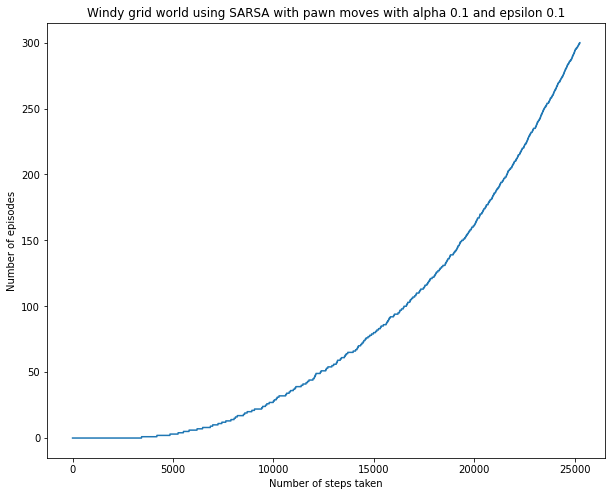


Total number of steps taken to reach to 300 Episodes is 29659


Optimial path using SARSA with pawn moves with alpha: 0.1 and epsilon: 0.3
[[ 0.  0.  0. 11. 18. 19. 20. 22. 23. 24.]
 [ 0.  0.  0.  7.  0.  0.  0.  0.  0. 25.]
 [ 0.  0.  4.  0.  0.  0.  0.  0. 28. 29.]
 [ 1.  2.  3.  0.  0.  0.  0. 39.  0. 30.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 32.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 38. 33.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 36.]]


SARSA with pawn moves took 39 steps with alpha 0.1 and epsilon 0.3 to reach to the goal state


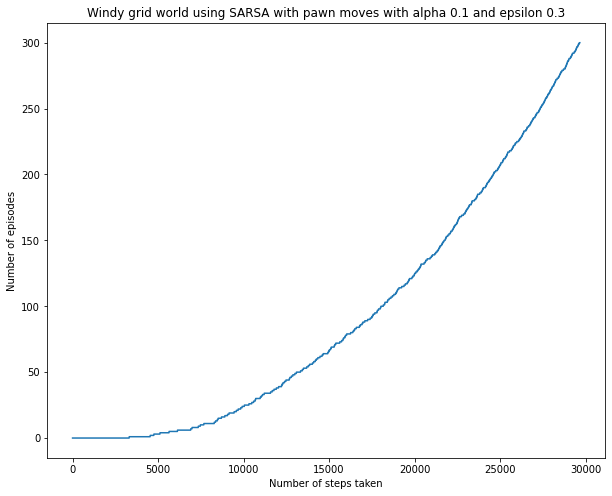


Total number of steps taken to reach to 300 Episodes is 45277


Optimial path using SARSA with pawn moves with alpha: 0.1 and epsilon: 0.5
[[  0.   0.   0.   0.  44.  47. 133. 135. 136. 137.]
 [  0.   0.  18.  17.   0.  42.   0.  75. 113. 140.]
 [  0.   0.  19.   0.  41.   0.   0. 131. 122. 145.]
 [  1.  21.  22.   0.   0.  40.   0. 156.  63. 148.]
 [  2.  24.  23.   0.  39.   0.   0.   0. 130. 151.]
 [ 30.  27.   0.  38.   0.   0.   0.   0. 155. 152.]
 [ 35.  36.  37.   0.   0.   0.   0.   0.   0. 154.]]


SARSA with pawn moves took 156 steps with alpha 0.1 and epsilon 0.5 to reach to the goal state


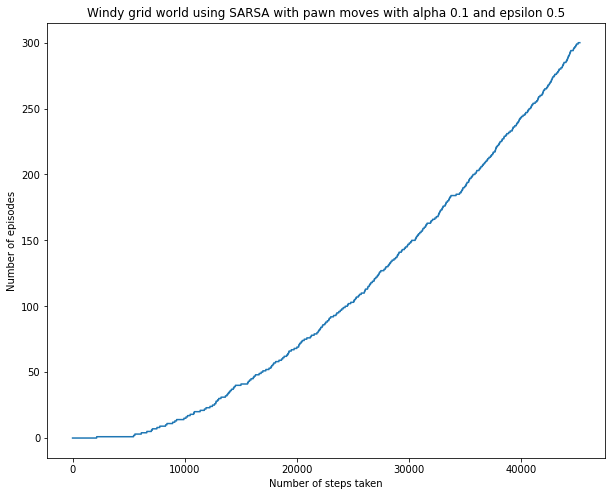


Total number of steps taken to reach to 300 Episodes is 13680


Optimial path using SARSA with pawn moves with alpha: 0.3 and epsilon: 0.1
[[ 0.  0.  0.  0.  0.  6.  8.  9. 10. 11.]
 [ 0.  0.  0.  0.  5.  0.  0.  0.  0. 12.]
 [ 0.  0.  0.  4.  0.  0.  0.  0.  0. 13.]
 [ 1.  2.  3.  0.  0.  0.  0. 19.  0. 14.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 15.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 18. 16.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 17.]]


SARSA with pawn moves took 19 steps with alpha 0.3 and epsilon 0.1 to reach to the goal state


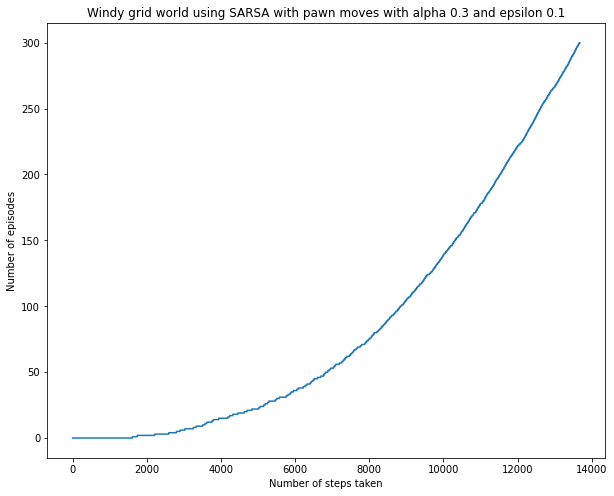


Total number of steps taken to reach to 300 Episodes is 18681


Optimial path using SARSA with pawn moves with alpha: 0.3 and epsilon: 0.3
[[ 0.  0.  0.  0.  0.  0. 30. 33. 34. 35.]
 [ 0.  0.  0.  0.  0.  0. 29.  0.  0. 37.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 38.]
 [ 1.  0.  0.  0.  0. 28.  0. 44.  0. 39.]
 [ 3.  0.  0.  0. 27.  0.  0.  0.  0. 40.]
 [16. 23. 24. 26.  0.  0.  0.  0. 43. 41.]
 [12. 18. 25.  0.  0.  0.  0.  0.  0. 42.]]


SARSA with pawn moves took 44 steps with alpha 0.3 and epsilon 0.3 to reach to the goal state


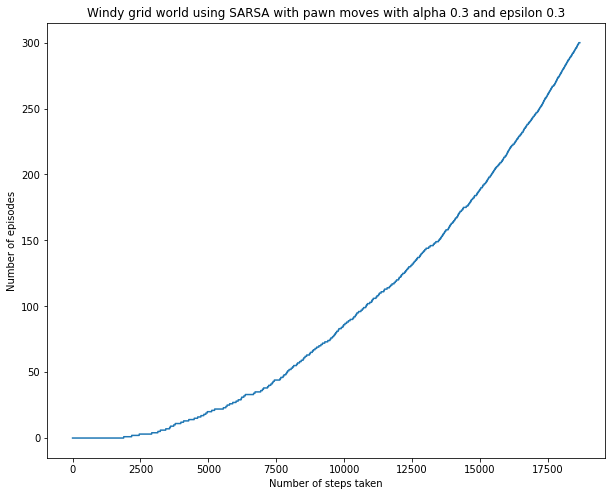


Total number of steps taken to reach to 300 Episodes is 31986


Optimial path using SARSA with pawn moves with alpha: 0.3 and epsilon: 0.5
[[ 0.  0.  0.  8.  9. 12. 15. 16. 25. 27.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 28.]
 [ 0.  0.  0.  6.  0.  0.  0.  0.  0. 29.]
 [ 1.  2.  5.  0.  0.  0.  0. 47.  0. 30.]
 [ 0.  3.  4.  0.  0.  0.  0.  0. 39. 40.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 46. 43.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 45.]]


SARSA with pawn moves took 47 steps with alpha 0.3 and epsilon 0.5 to reach to the goal state


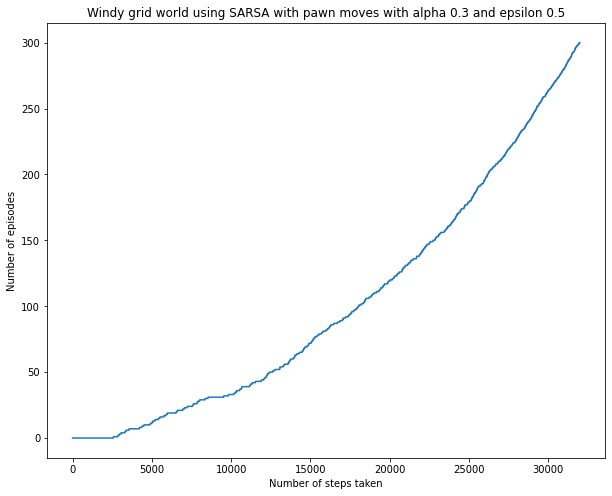


Total number of steps taken to reach to 300 Episodes is 11321


Optimial path using SARSA with pawn moves with alpha: 0.5 and epsilon: 0.1
[[ 0.  0.  0.  0.  0.  7. 10. 11. 12. 14.]
 [ 0.  0.  0.  0.  5.  0.  0.  0.  0. 15.]
 [ 0.  0.  0.  4.  0.  0.  0.  0.  0. 16.]
 [ 1.  2.  3.  0.  0.  0.  0. 22.  0. 17.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 18.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 21. 19.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 20.]]


SARSA with pawn moves took 22 steps with alpha 0.5 and epsilon 0.1 to reach to the goal state


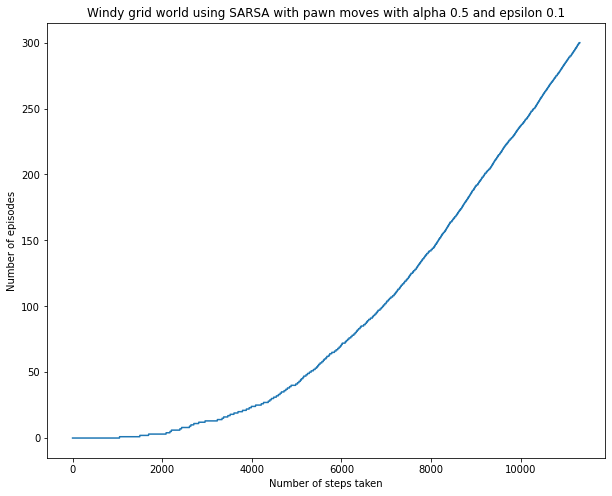


Total number of steps taken to reach to 300 Episodes is 17164


Optimial path using SARSA with pawn moves with alpha: 0.5 and epsilon: 0.3
[[ 0.  0. 11. 17. 18. 19. 20. 21. 22. 24.]
 [ 0.  0.  0.  7.  0.  0.  0.  0.  0. 25.]
 [ 0.  0.  0.  0.  6.  0.  0.  0.  0. 26.]
 [ 1.  2.  0.  5.  0.  0.  0. 33.  0. 28.]
 [ 0.  3.  4.  0.  0.  0.  0.  0.  0. 29.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 32. 30.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 31.]]


SARSA with pawn moves took 33 steps with alpha 0.5 and epsilon 0.3 to reach to the goal state


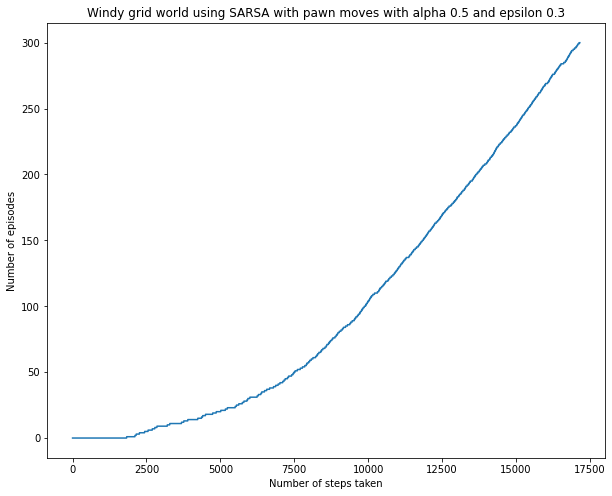


Total number of steps taken to reach to 300 Episodes is 29975


Optimial path using SARSA with pawn moves with alpha: 0.5 and epsilon: 0.5
[[  9.   0. 103. 106. 108. 109. 110. 132. 133. 134.]
 [ 13.   0.   0.   0.   0.  26.   0.   0. 131. 135.]
 [ 14.   0.   0.   0.  25.   0.   0.   0.  94. 136.]
 [ 15.  16.   0.  24.   0.   0.   0. 153.   0. 137.]
 [  0.  17.  23.  22.   0.   0.   0.   0.  82. 138.]
 [  0.   0.  19.   0.   0.   0.   0.   0. 152. 148.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0. 151.]]


SARSA with pawn moves took 153 steps with alpha 0.5 and epsilon 0.5 to reach to the goal state


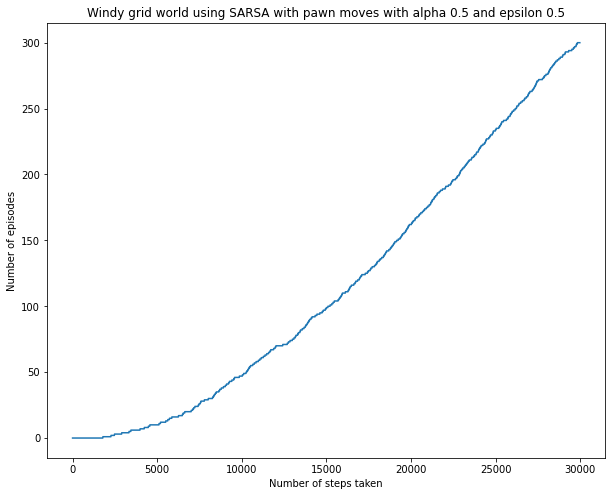

In [19]:
print("Start learning SARSA agent with pawn moves")
world = WindyGridWorld(pawn_moves=True,king_moves=False,stochastic=False)
world.predifend_states(start_state,terminal_state)
for i in range(len(alpha)):
    for j in range(len(epsilon)):
        solve = SolveWindyGridWorld(world, start_state,terminal_state,sarsa=True,q_learning=False,alpha=alpha[i],epsilon=epsilon[j],gamma=1)
        solve.solve_windy_grid_world()

### Start learning SARSA agent with stochastic king moves and 30000 Episods with different values of alpha and epsilon.

Start learning SARSA agent with stochastic king moves

Total number of steps taken to reach to 300 Episodes is 47977


Optimial path using SARSA with stochastic king moves with alpha: 0.1 and epsilon: 0.1
[[ 0. 20. 19. 45.  6. 41.  0.  0.  0.  0.]
 [ 0. 13.  0. 46. 44. 42.  0.  0.  0.  0.]
 [21. 12. 67. 65. 63. 26.  0.  0.  0.  0.]
 [ 1. 48. 49. 62. 64.  0.  0. 82.  0.  0.]
 [ 0. 11. 68. 58. 78. 80. 81.  0.  0.  0.]
 [71. 74. 76. 77.  0. 79.  0.  0.  0.  0.]
 [72. 75. 55. 56.  0.  0.  0.  0.  0.  0.]]


SARSA with stochastic king moves took 82 steps with alpha 0.1 and epsilon 0.1 to reach to the goal state


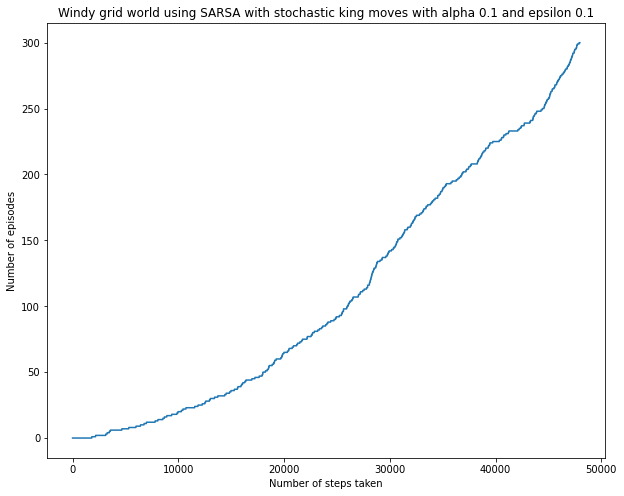


Total number of steps taken to reach to 300 Episodes is 45115


Optimial path using SARSA with stochastic king moves with alpha: 0.1 and epsilon: 0.3
[[ 0.  0.  0.  0.  0. 13.  0. 17. 18.  0.]
 [ 0.  0.  7.  0. 11. 12. 14. 15. 16. 21.]
 [ 0.  0.  0.  8.  9.  0.  0.  0.  0. 22.]
 [ 1.  0.  0.  0.  0.  0.  0. 27.  0.  0.]
 [ 0.  2.  0.  0.  0.  0.  0.  0.  0. 24.]
 [ 0.  0.  0.  5.  0.  0.  0.  0.  0.  0.]
 [ 0.  3.  4.  0.  0.  0.  0.  0. 26. 25.]]


SARSA with stochastic king moves took 27 steps with alpha 0.1 and epsilon 0.3 to reach to the goal state


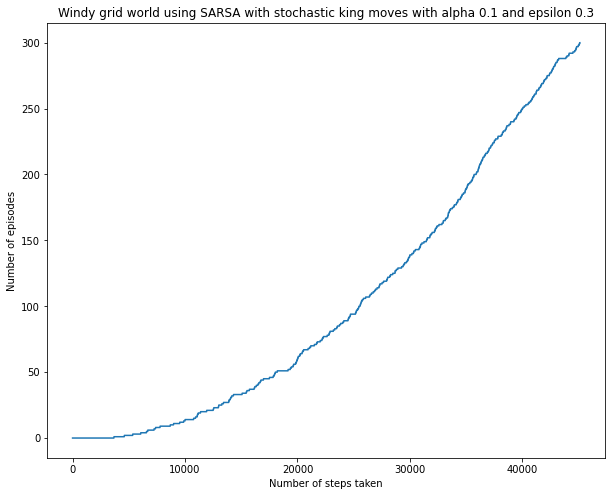


Total number of steps taken to reach to 300 Episodes is 60734


Optimial path using SARSA with stochastic king moves with alpha: 0.1 and epsilon: 0.5
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 13.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 12.  0. 14.  0.]
 [ 1.  0.  0.  0.  0. 11. 19. 20.  0. 15.]
 [ 0.  3.  4.  0. 10.  0.  0. 18.  0.  0.]
 [ 2.  0.  0.  5.  6.  0.  0.  0. 17. 16.]
 [ 0.  0.  0.  0.  0.  7.  0.  0.  0.  0.]]


SARSA with stochastic king moves took 20 steps with alpha 0.1 and epsilon 0.5 to reach to the goal state


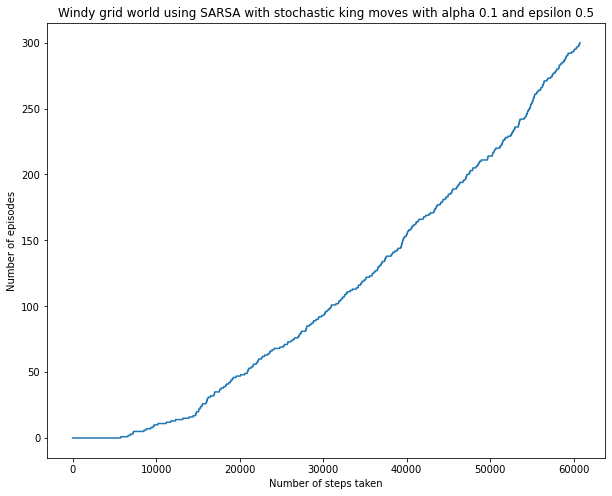


Total number of steps taken to reach to 300 Episodes is 29638


Optimial path using SARSA with stochastic king moves with alpha: 0.3 and epsilon: 0.1
[[19.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [20. 21. 24.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 25.  0.  0.  0.  0.  0.  0.  0.  0.]
 [13. 10.  7.  0.  0.  0.  0. 35.  0.  0.]
 [12.  5. 26.  0. 29. 30.  0. 33.  0.  0.]
 [ 4.  0. 27. 28.  0. 31. 32.  0. 34.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


SARSA with stochastic king moves took 35 steps with alpha 0.3 and epsilon 0.1 to reach to the goal state


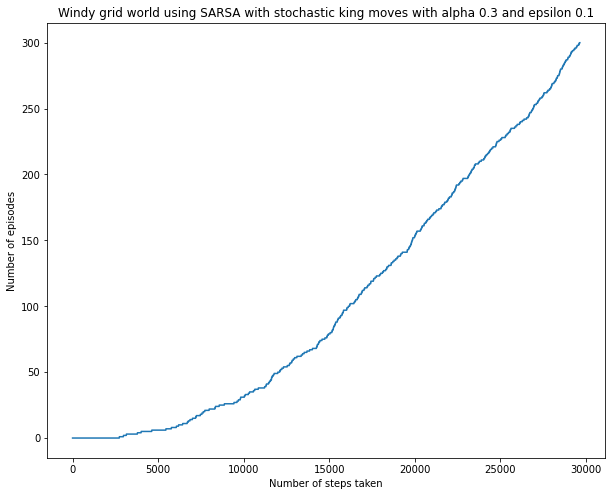


Total number of steps taken to reach to 300 Episodes is 41236


Optimial path using SARSA with stochastic king moves with alpha: 0.3 and epsilon: 0.3
[[  3.   0.   0.   0.  20.  23.  24.   0. 108.  71.]
 [  2.   0.   0.   0.   0.   0.   0.  66.  82. 114.]
 [  4.   0.   0.   0.   0.   0.   0. 104.  40. 112.]
 [  1.  14.  16.  19.   0.   0.   0. 122. 103. 115.]
 [  0.   5.  13.  18.   0.   0.   0. 102.  94. 116.]
 [  0.   0.  17.   7.   0.   0.   0. 121.  99. 119.]
 [  0.  12.  10.   0.   0.   0.   0.   0. 120. 118.]]


SARSA with stochastic king moves took 122 steps with alpha 0.3 and epsilon 0.3 to reach to the goal state


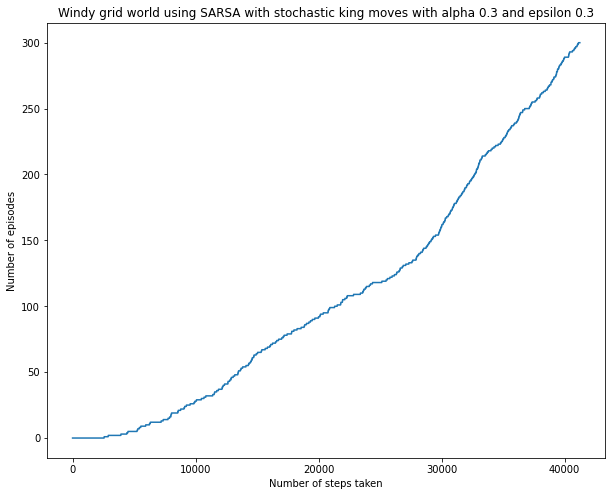


Total number of steps taken to reach to 300 Episodes is 50716


Optimial path using SARSA with stochastic king moves with alpha: 0.3 and epsilon: 0.5
[[  0.   0.   0.   0.  40. 106. 113. 114.  97.  95.]
 [  0.   0.   0.   0.  20.  41.  68. 110. 115.  98.]
 [  0.   0.   0.   0.   0.   0.  15.  37.  93. 116.]
 [  1.   0.   0.   0.   0.   0.   0. 121.  87. 117.]
 [  6.   3.   0.  11.   0.  14.   0.   0. 118.  92.]
 [  8.   9.   0.   0.  12.  13.   0.   0. 120.  35.]
 [  7.   0.  10.   0.   0.   0.   0.   0.  33.  58.]]


SARSA with stochastic king moves took 121 steps with alpha 0.3 and epsilon 0.5 to reach to the goal state


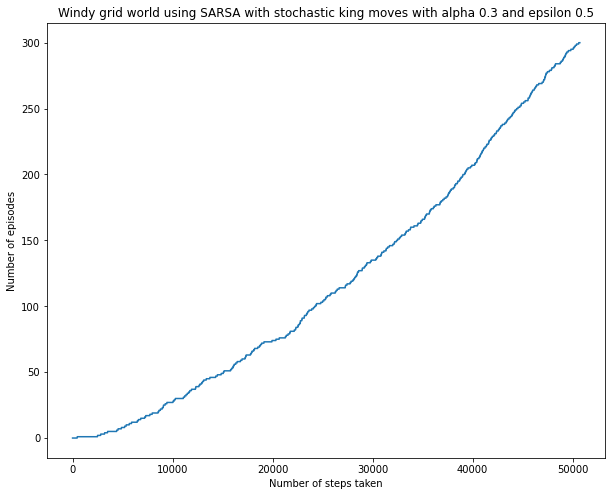


Total number of steps taken to reach to 300 Episodes is 29159


Optimial path using SARSA with stochastic king moves with alpha: 0.5 and epsilon: 0.1
[[ 0.  0.  0.  0.  0.  0. 10.  0. 12. 14.]
 [ 0.  0.  0.  0.  0.  0.  0. 11.  0.  0.]
 [ 0.  0.  4.  0.  8.  9.  0.  0.  0. 16.]
 [ 1.  2.  3.  5.  7.  0.  0. 20.  0. 17.]
 [ 0.  0.  0.  6.  0.  0.  0.  0. 19.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 18.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


SARSA with stochastic king moves took 20 steps with alpha 0.5 and epsilon 0.1 to reach to the goal state


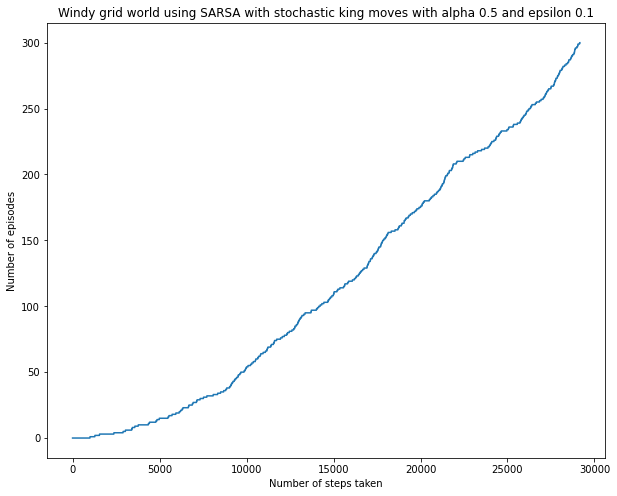


Total number of steps taken to reach to 300 Episodes is 39647


Optimial path using SARSA with stochastic king moves with alpha: 0.5 and epsilon: 0.3
[[ 92.  67.  90.  80.  77. 171. 145. 173. 174. 175.]
 [ 88.  91.  85.  83.   0.   0. 172. 143. 148. 176.]
 [ 93. 106. 108.  84.   0. 170. 142.   0.   0. 178.]
 [ 12. 116. 115.  27. 140.   0.   0. 186. 183. 181.]
 [124. 125. 105. 130. 138. 139. 169. 168. 160. 182.]
 [120. 134. 135. 137.   0.   0.   0.   0. 185. 184.]
 [123. 133. 136. 102.   0.   0.   0.   0.   0.   0.]]


SARSA with stochastic king moves took 186 steps with alpha 0.5 and epsilon 0.3 to reach to the goal state


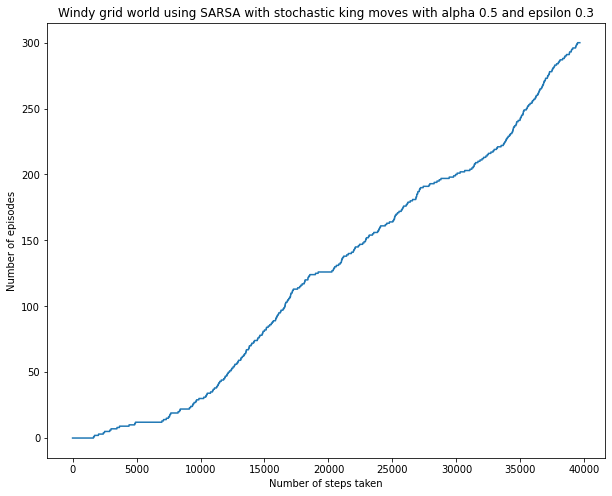


Total number of steps taken to reach to 300 Episodes is 66833


Optimial path using SARSA with stochastic king moves with alpha: 0.5 and epsilon: 0.5
[[ 87.  86.  85. 109. 108.   0. 199. 179. 203. 202.]
 [ 88.  43. 112. 113. 116. 172. 177. 200. 138. 220.]
 [ 91.  97.  40. 107.   0. 115.  74. 212. 217. 219.]
 [ 98. 111.  61.  67.  68. 198.   0. 226. 213. 222.]
 [ 31.  99. 106.  95.   0.  73. 197. 196. 211. 210.]
 [  7. 105. 104.   0.  70.   0.   0. 225. 224. 223.]
 [  6. 101.  94.  71.  72.   0.   0.   0.   0. 194.]]


SARSA with stochastic king moves took 226 steps with alpha 0.5 and epsilon 0.5 to reach to the goal state


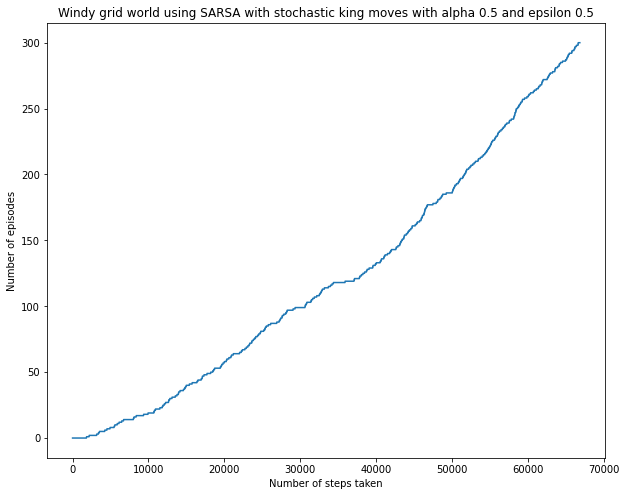

In [20]:
world = WindyGridWorld(pawn_moves=False,king_moves=True, stochastic=True)
world.predifend_states(start_state,terminal_state)
print("Start learning SARSA agent with stochastic king moves")
for i in range(len(alpha)):
    for j in range(len(epsilon)):
        solve = SolveWindyGridWorld(world, start_state,terminal_state,sarsa=True,q_learning=False,alpha=alpha[i],epsilon=epsilon[j],gamma=1)
        solve.solve_windy_grid_world()

### Start learning Q-learning agent with pawn moves and 30000 Episods with different values of alpha and epsilon.

Start learning Q-learning agent with pawn moves

Total number of steps taken to reach to 300 Episodes is 24897


Optimial path using Q-learning with pawn moves with alpha: 0.1 and epsilon: 0.1
[[ 0.  0.  0.  0.  0. 12. 13. 14. 15. 16.]
 [ 0.  0.  0.  0. 11.  0.  0.  0.  0. 17.]
 [ 0.  0.  0. 10.  0.  0.  0.  0.  0. 18.]
 [ 1.  4.  7.  0.  0.  0.  0. 29.  0. 19.]
 [ 0.  3.  6.  0.  0.  0.  0.  0.  0. 22.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 28. 26.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 27.]]


Q_learning with pawn moves took 29 steps with alpha 0.1 and epsilon 0.1 to reach to the goal state


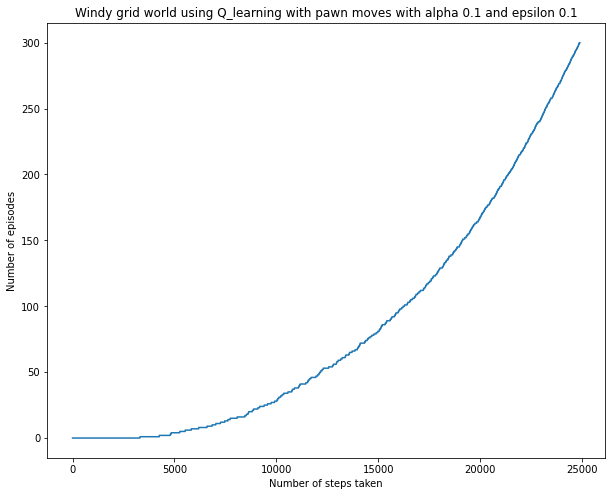


Total number of steps taken to reach to 300 Episodes is 27389


Optimial path using Q-learning with pawn moves with alpha: 0.1 and epsilon: 0.3
[[ 0.  0.  0. 19. 20. 23. 24. 25. 29. 31.]
 [ 0.  0.  0. 17.  0.  0.  0.  0.  0. 32.]
 [ 0.  0.  0.  0. 16.  0.  0.  0.  0. 33.]
 [ 1.  0.  0.  0.  0.  0.  0. 41.  0. 34.]
 [ 6.  3.  0.  0. 15.  0.  0.  0.  0. 37.]
 [ 7. 11.  0. 14.  0.  0.  0.  0. 40. 38.]
 [ 9. 12. 13.  0.  0.  0.  0.  0.  0. 39.]]


Q_learning with pawn moves took 41 steps with alpha 0.1 and epsilon 0.3 to reach to the goal state


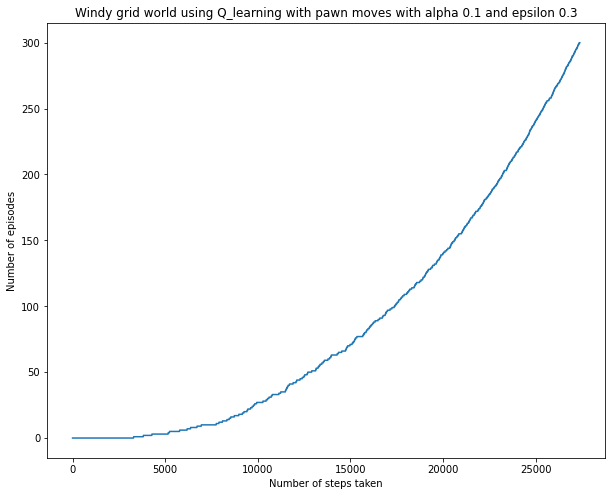


Total number of steps taken to reach to 300 Episodes is 34167


Optimial path using Q-learning with pawn moves with alpha: 0.1 and epsilon: 0.5
[[ 0.  0.  0.  0.  0. 21. 24. 29. 37. 50.]
 [ 0.  0.  0.  0. 18.  0.  0.  0. 48. 53.]
 [ 0.  0.  0. 17.  0.  0.  0.  0. 60. 61.]
 [ 1. 15. 16.  9.  0.  0.  0. 68. 47. 62.]
 [ 0. 14. 13.  0.  0.  0.  0.  0. 59. 64.]
 [ 0.  4. 12.  0.  0.  0.  0.  0. 67. 65.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 66.]]


Q_learning with pawn moves took 68 steps with alpha 0.1 and epsilon 0.5 to reach to the goal state


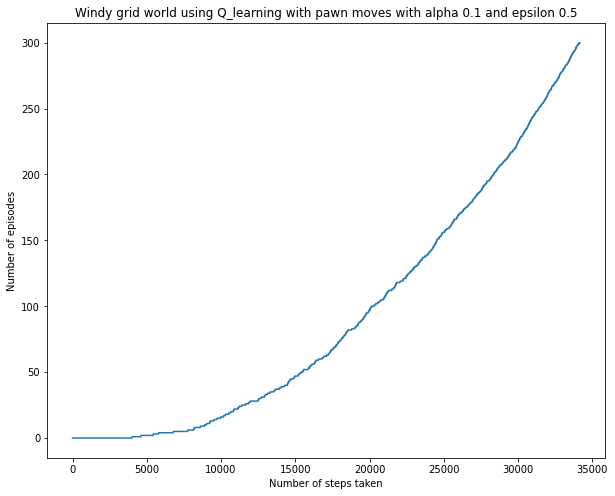


Total number of steps taken to reach to 300 Episodes is 13345


Optimial path using Q-learning with pawn moves with alpha: 0.3 and epsilon: 0.1
[[ 0.  0.  0.  0.  0.  6.  7.  8. 11. 12.]
 [ 0.  0.  0.  0.  5.  0.  0.  0.  0. 13.]
 [ 0.  0.  0.  4.  0.  0.  0.  0.  0. 14.]
 [ 1.  2.  3.  0.  0.  0.  0. 20.  0. 15.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 16.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 19. 17.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 18.]]


Q_learning with pawn moves took 20 steps with alpha 0.3 and epsilon 0.1 to reach to the goal state


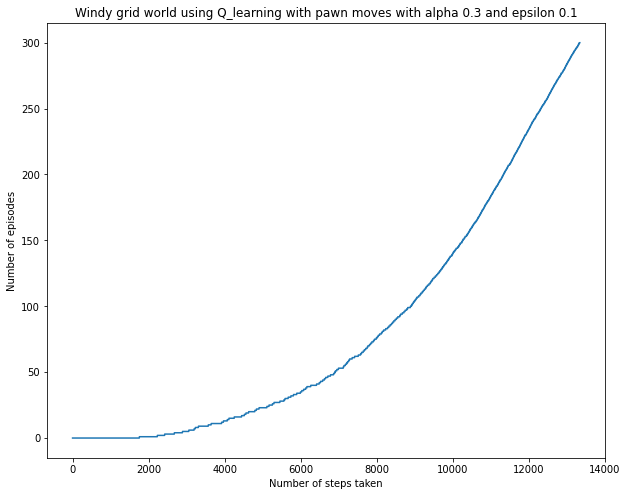


Total number of steps taken to reach to 300 Episodes is 15805


Optimial path using Q-learning with pawn moves with alpha: 0.3 and epsilon: 0.3
[[ 0.  0.  0.  9. 10. 11. 12. 13. 14. 15.]
 [ 0.  0.  0.  5.  0.  0.  0.  0. 19. 20.]
 [ 0.  3.  4.  0.  0.  0.  0.  0.  0. 22.]
 [ 1.  2.  0.  0.  0.  0.  0. 29.  0. 23.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 25.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 28. 26.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 27.]]


Q_learning with pawn moves took 29 steps with alpha 0.3 and epsilon 0.3 to reach to the goal state


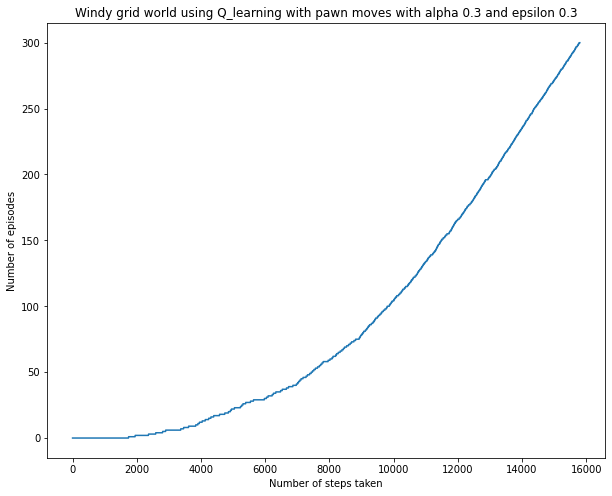


Total number of steps taken to reach to 300 Episodes is 21984


Optimial path using Q-learning with pawn moves with alpha: 0.3 and epsilon: 0.5
[[  0.   0.   0.   5.   6.   8.  14.  60.  94.  98.]
 [  0.   0.   0.   0.   0.   0.   0.  28.  89. 105.]
 [  0.   0.   0.   4.   0.   0.   0.   0.   0. 106.]
 [  1.   2.   3.   0.   0.   0.   0. 116. 109. 110.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0. 111.]
 [  0.   0.   0.   0.   0.   0.   0.   0. 115. 112.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0. 113.]]


Q_learning with pawn moves took 116 steps with alpha 0.3 and epsilon 0.5 to reach to the goal state


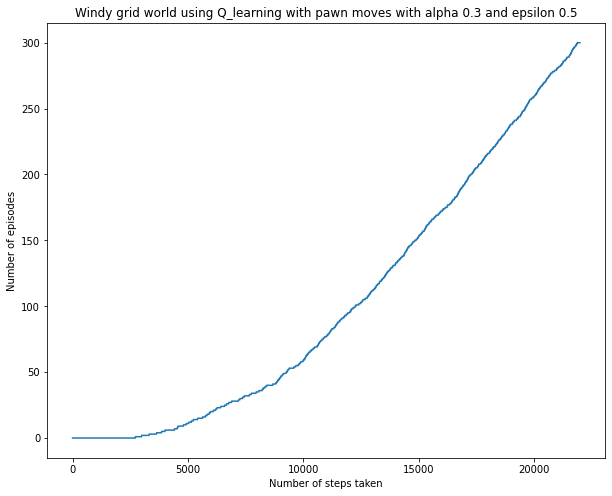


Total number of steps taken to reach to 300 Episodes is 10630


Optimial path using Q-learning with pawn moves with alpha: 0.5 and epsilon: 0.1
[[ 0.  0.  0.  0.  0.  6.  7.  8.  9. 10.]
 [ 0.  0.  0.  0.  5.  0.  0.  0.  0. 11.]
 [ 0.  0.  0.  4.  0.  0.  0.  0.  0. 12.]
 [ 1.  2.  3.  0.  0.  0.  0. 18.  0. 13.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 14.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 17. 15.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 16.]]


Q_learning with pawn moves took 18 steps with alpha 0.5 and epsilon 0.1 to reach to the goal state


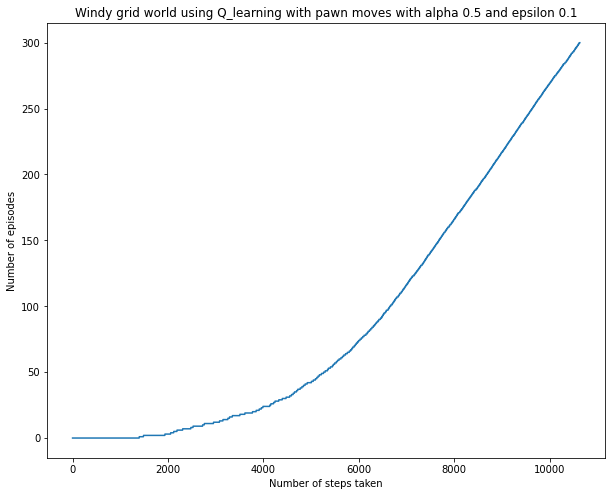


Total number of steps taken to reach to 300 Episodes is 13291


Optimial path using Q-learning with pawn moves with alpha: 0.5 and epsilon: 0.3
[[ 0.  0.  0.  0.  0.  7.  8. 10. 15. 16.]
 [ 0.  0.  0.  0.  6.  0.  0.  0.  0. 17.]
 [ 0.  0.  0.  5.  0.  0.  0.  0.  0. 18.]
 [ 2.  3.  4.  0.  0.  0.  0. 25.  0. 19.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 20.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 24. 21.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 23.]]


Q_learning with pawn moves took 25 steps with alpha 0.5 and epsilon 0.3 to reach to the goal state


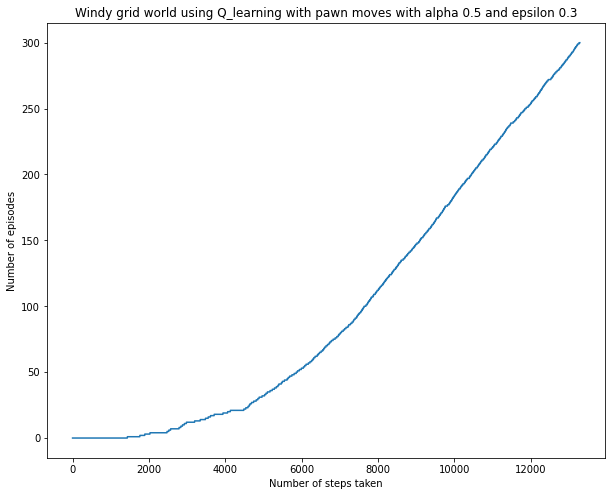


Total number of steps taken to reach to 300 Episodes is 19496


Optimial path using Q-learning with pawn moves with alpha: 0.5 and epsilon: 0.5
[[ 0.  0.  0.  0.  0. 10. 14. 15. 17. 19.]
 [ 0.  0.  0.  0.  5.  0.  0.  0.  0. 20.]
 [ 0.  0.  0.  4.  0.  0.  0.  0.  0. 24.]
 [ 1.  2.  3.  0.  0.  0.  0. 39. 33. 34.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 35.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 38. 36.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 37.]]


Q_learning with pawn moves took 39 steps with alpha 0.5 and epsilon 0.5 to reach to the goal state


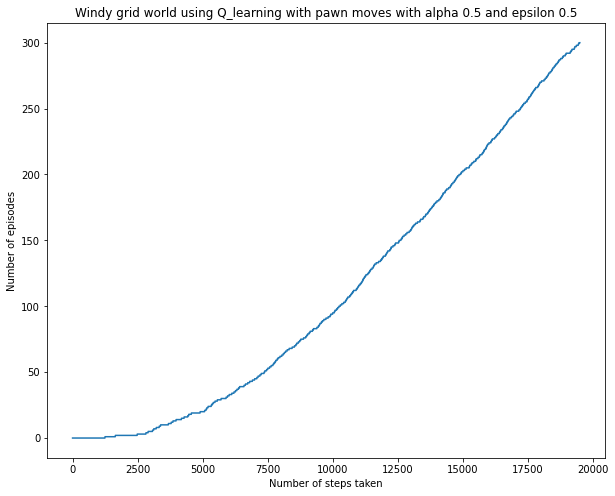

In [21]:
print("Start learning Q-learning agent with pawn moves")
world = WindyGridWorld(pawn_moves=True,king_moves=False,stochastic=False)
world.predifend_states(start_state,terminal_state)
for i in range(len(alpha)):
    for j in range(len(epsilon)):
        solve = SolveWindyGridWorld(world, start_state,terminal_state,sarsa=False,q_learning=True,alpha=alpha[i],epsilon=epsilon[j],gamma=1)
        solve.solve_windy_grid_world()


### Start learning Q-learning agent with stochastic king moves and 30000 Episods with different values of alpha and epsilon.

Start learning Q-learning agent with stochastic king moves

Total number of steps taken to reach to 300 Episodes is 45137


Optimial path using Q-learning with stochastic king moves with alpha: 0.1 and epsilon: 0.1
[[ 0.  0.  0.  0.  0. 11. 12. 14.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 13.  0. 15.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 18.]
 [ 1.  0.  0.  0.  0.  0.  9. 21.  0. 19.]
 [ 0.  0.  0.  0.  0.  0.  7.  8. 20.  0.]
 [ 0.  2.  3.  4.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  5.  6.  0.  0.  0.  0.]]


Q_learning with stochastic king moves took 21 steps with alpha 0.1 and epsilon 0.1 to reach to the goal state


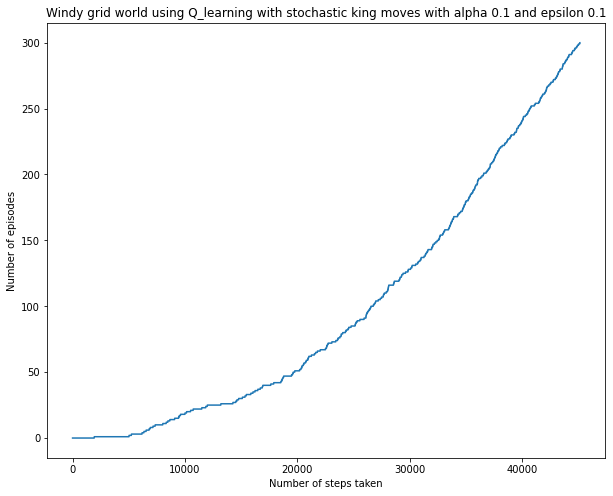


Total number of steps taken to reach to 300 Episodes is 43413


Optimial path using Q-learning with stochastic king moves with alpha: 0.1 and epsilon: 0.3
[[149. 139. 129. 126. 157. 124. 159. 162. 113. 101.]
 [144. 150. 151.  90. 156. 158.  15. 160. 167. 168.]
 [148. 130.  82.  77.  85.  67.   0. 166. 161. 117.]
 [ 54.   0. 152.  84.   0.   0.  14. 173. 165. 169.]
 [  3.   0.   0. 153. 154. 155.   0.   0. 120. 170.]
 [  6.  57.   0.  63.  11.  65.  66. 172. 171. 119.]
 [  5.   0.  62.  10.  64.   0.   0.   0.   0.   0.]]


Q_learning with stochastic king moves took 173 steps with alpha 0.1 and epsilon 0.3 to reach to the goal state


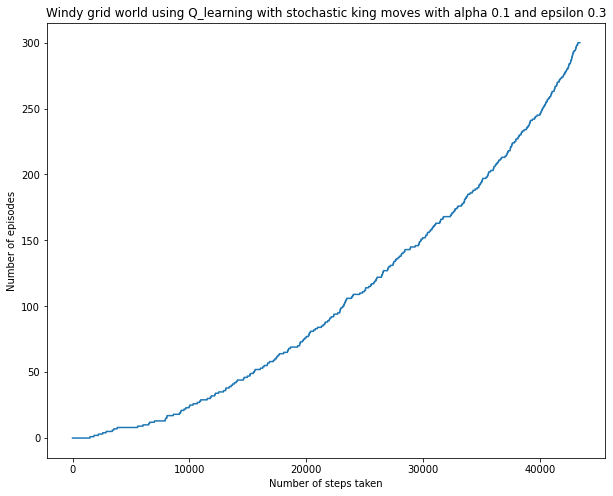


Total number of steps taken to reach to 300 Episodes is 55830


Optimial path using Q-learning with stochastic king moves with alpha: 0.1 and epsilon: 0.5
[[ 0.  0. 16.  0. 14. 13.  0.  0.  0.  0.]
 [ 0. 17.  0. 15. 12.  0. 56. 57. 58.  0.]
 [ 0. 41. 38.  0. 53. 54.  0.  0.  0.  0.]
 [20.  0. 40. 35.  0. 30.  0. 67. 63. 62.]
 [43. 19. 39.  0. 31.  6.  0.  0. 66. 60.]
 [23. 46.  3. 51. 52.  7.  0.  0. 65. 64.]
 [44. 45. 49.  4.  0.  0.  0.  0.  0.  0.]]


Q_learning with stochastic king moves took 67 steps with alpha 0.1 and epsilon 0.5 to reach to the goal state


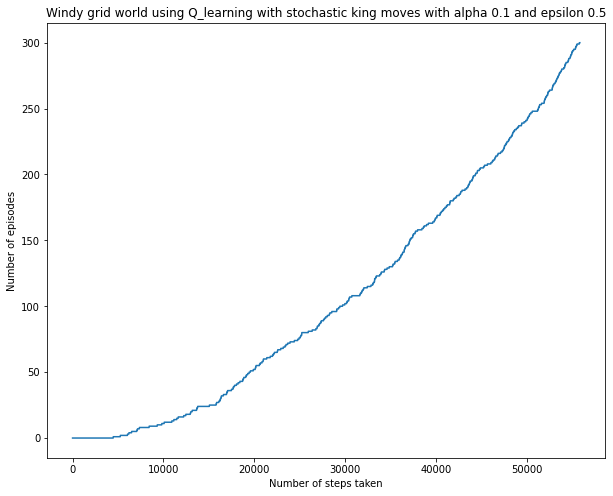


Total number of steps taken to reach to 300 Episodes is 30660


Optimial path using Q-learning with stochastic king moves with alpha: 0.3 and epsilon: 0.1
[[ 0.  0.  0.  0.  0.  0.  0.  0. 32.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 31.  0.  0.]
 [ 0.  2.  0.  0.  0.  0.  0.  0.  0. 34.]
 [ 7. 14.  0.  0.  0. 29. 30. 42. 39.  0.]
 [13. 18. 16. 23. 26.  0.  0.  0. 38. 35.]
 [ 0. 19.  0. 25.  0. 27.  0.  0. 41. 40.]
 [11. 21. 24.  0.  0.  0.  0.  0.  0.  0.]]


Q_learning with stochastic king moves took 42 steps with alpha 0.3 and epsilon 0.1 to reach to the goal state


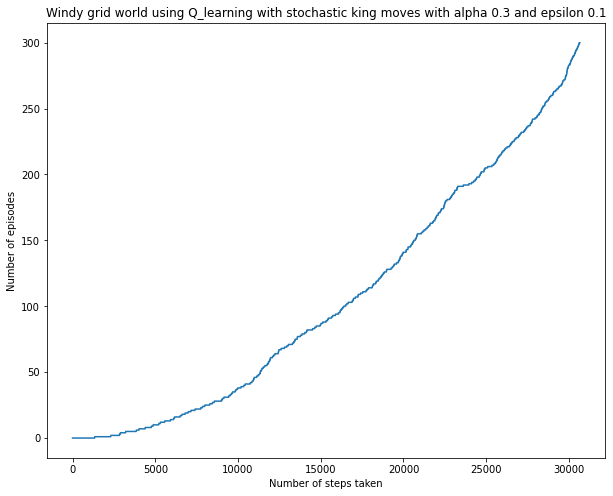


Total number of steps taken to reach to 300 Episodes is 33054


Optimial path using Q-learning with stochastic king moves with alpha: 0.3 and epsilon: 0.3
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 16. 15.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 14. 17.  0.]
 [ 1.  0.  0.  0.  0.  0.  0. 25.  0.  0.]
 [ 0.  0.  0.  0. 10.  0.  0. 24.  0. 18.]
 [ 2.  0.  0.  7.  8. 11. 12.  0.  0. 19.]
 [ 4.  5.  6.  0.  0.  0.  0.  0. 22. 21.]]


Q_learning with stochastic king moves took 25 steps with alpha 0.3 and epsilon 0.3 to reach to the goal state


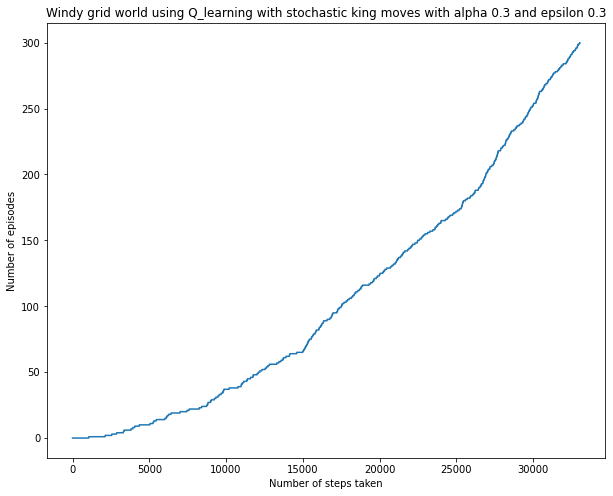


Total number of steps taken to reach to 300 Episodes is 37317


Optimial path using Q-learning with stochastic king moves with alpha: 0.3 and epsilon: 0.5
[[ 4.  6.  0.  0.  0.  0.  0.  0. 17.  0.]
 [ 0.  7.  0.  0.  0.  0.  0. 16.  0. 19.]
 [ 3.  0.  0.  0.  0.  0.  0.  0.  0. 20.]
 [ 1.  2.  8.  0.  0.  0. 15. 28.  0. 22.]
 [ 0.  0. 10.  0.  0. 14.  0.  0.  0. 24.]
 [ 0.  0. 11. 12. 13.  0.  0.  0. 27.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 26.]]


Q_learning with stochastic king moves took 28 steps with alpha 0.3 and epsilon 0.5 to reach to the goal state


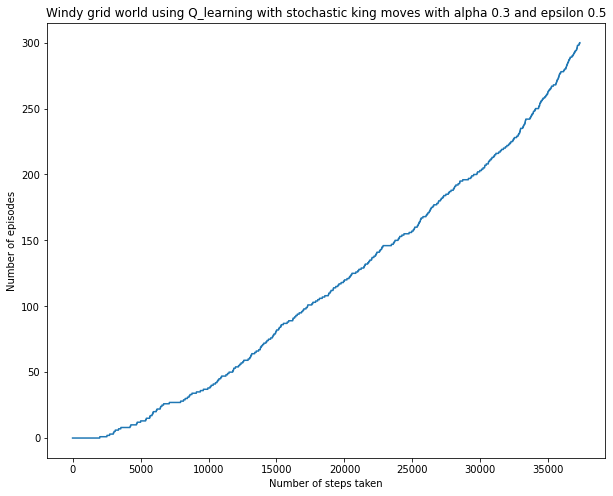


Total number of steps taken to reach to 300 Episodes is 27207


Optimial path using Q-learning with stochastic king moves with alpha: 0.5 and epsilon: 0.1
[[ 0.  0.  0.  0.  0.  0. 17. 18.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 20. 21. 31. 33.]
 [ 0.  0.  0. 12.  0.  0.  0. 30.  0. 32.]
 [ 1.  2.  3. 13.  0. 15. 16. 38.  0. 35.]
 [ 0.  0.  6. 10. 14.  0.  0.  0. 29. 36.]
 [ 0.  0.  0.  7.  0.  0.  0.  0. 37.  0.]
 [ 0.  0.  0.  8.  0.  0.  0.  0.  0.  0.]]


Q_learning with stochastic king moves took 38 steps with alpha 0.5 and epsilon 0.1 to reach to the goal state


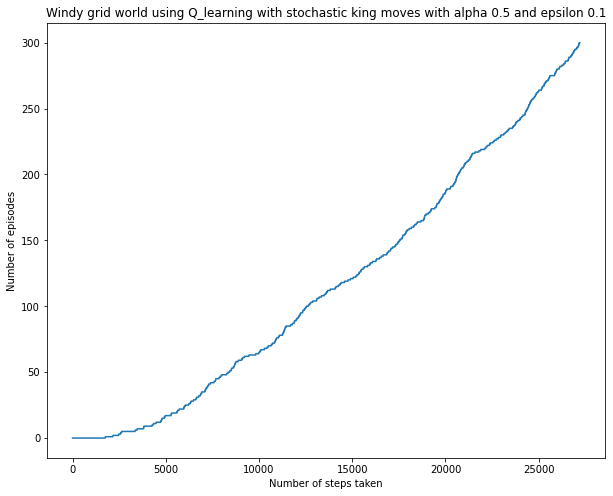


Total number of steps taken to reach to 300 Episodes is 29008


Optimial path using Q-learning with stochastic king moves with alpha: 0.5 and epsilon: 0.3
[[  0.   0.   0.   0.   0.   0.  94.  95.  68. 100.]
 [  2.   0.   0.   0.   0.   0.  25.  93.  96. 101.]
 [  4.   0.   0.   0.   0.  18.   0.  84.  92. 102.]
 [  7.   5.   0.   0.   0.  15.   0. 106.  89.  98.]
 [  0.   0.   0.   0.   0.   0.   0. 105. 104. 103.]
 [  8.   9.   0.   0.  12.   0.   0.   0.  76.  88.]
 [  0.   0.  10.  11.  14.  13.   0.   0.   0.   0.]]


Q_learning with stochastic king moves took 106 steps with alpha 0.5 and epsilon 0.3 to reach to the goal state


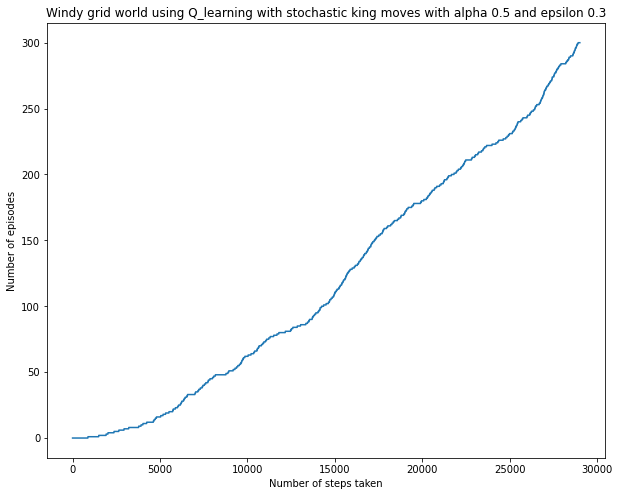


Total number of steps taken to reach to 300 Episodes is 38039


Optimial path using Q-learning with stochastic king moves with alpha: 0.5 and epsilon: 0.5
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 13.  0.  0.  0.  0.  0.  0.]
 [ 3.  4.  0. 14. 15.  0. 17. 18.  0.  0.]
 [ 0.  0.  0.  0. 12. 16.  0.  0.  0.  0.]
 [ 0.  0.  5. 10.  7.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 11.  9.  0.  0.  0.  0.  0.]]


Q_learning with stochastic king moves took 18 steps with alpha 0.5 and epsilon 0.5 to reach to the goal state


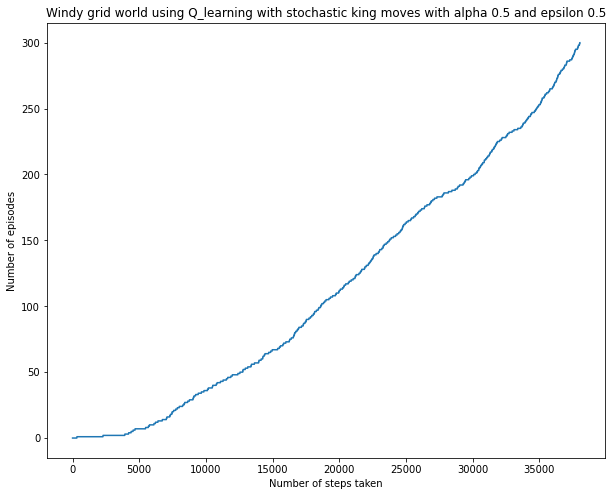

In [22]:
print("Start learning Q-learning agent with stochastic king moves")
world = WindyGridWorld(pawn_moves=False,king_moves=True,stochastic=True)
world.predifend_states(start_state,terminal_state)
for i in range(len(alpha)):
    for j in range(len(epsilon)):
        solve = SolveWindyGridWorld(world, start_state,terminal_state,sarsa=False,q_learning=True,alpha=alpha[i],epsilon=epsilon[j],gamma=1)
        solve.solve_windy_grid_world()